## import dependencies

In [91]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [92]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [93]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [94]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [95]:
%pip install matplotlib

In [96]:
import numpy as np
import pandas as pd
import tensorflow
from scipy.special import expit # normalization sigmoid function to get numbers from 0-1
import matplotlib.pyplot as plt


## import dataset 
using mnist dataset becasue its easy and well documented

In [97]:
from tensorflow.keras.datasets import mnist

In [98]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()

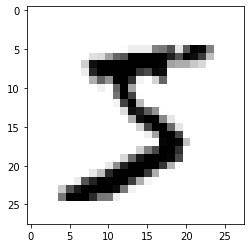

In [99]:
plt.imshow(train_set[0][:,:], cmap = plt.cm.binary)

In [100]:
train_set.shape

(60000, 28, 28)

In [101]:
train_set = train_set.reshape(60000,-1)/255
train_set.shape

(60000, 784)

In [102]:
test_set = test_set.reshape(10000, -1)/255
test_set.shape

(10000, 784)

In [103]:
def imshow(arr):
    plt.imshow( (arr.reshape(28,28) * 255)[:,:], cmap= plt.cm.binary)

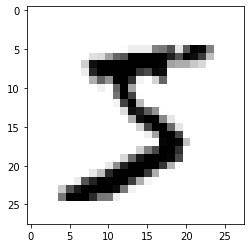

In [104]:
imshow(train_set[0])

In [105]:
train_label[0]

5

## Create the network

Generally:
- We need a set of weight `W` matrices, that represent how much emphasis each previous layer has on the next layer
- We need a set of bias `b` vectors, that represent how "often" a node/neuron is active
- we need a function to run through and add all of these neuron activations to see the results of our network
- We need an error function to check how good/ bad our results are, this will be used to determine how we will back propagate
- We need to use this error function to tell us how much to change our weights and biases

In [106]:
RAND_WEIGHT_INIT = 20

### The Feed Forward Algorithm ###
caclulate the output activations based on the previous activations, their weights affecting the current activations and the current node biases

In [107]:
# calc outputs for one layer
# @param previousActivations is the input to the next layer, this can either be the actual input data, or it can be the activations of a previous layer (size n)
# @param weightMatrix is a matrix of the weights that determine the next node layer's activation, (size n by m)
# @param nodeBiases are the biases applied to the activation layer we are trying to determine, (size n)
# @return nodes are the activations of the next layer's nodes (size m)
def prop_forward(previousActivations, weightMatrix, nodeBiases):
    return expit( (previousActivations @ weightMatrix) + nodeBiases) 
    # each node is the sum of positive and negative weights times the respective input, 
    # expit is the sigmoid applied to the node activations so that they are values between 0-1

use all of the weights and biases to determine each subsequent activation

In [108]:
def feed_forward(inputs, weights, biases):
    activations = []
    activations.append(inputs)

    for i, bias in enumerate(biases): # skips the output
        activations.append( prop_forward(activations[-1], weights[i], bias) )
    
    return activations


### The Back Propogation Algorithm ###
using (math) we take the final activations and compare with the desired activations using SE. Then we use the sigmoid function and its derivative (bc chain rule) on our multivariable activations to determine a 'best' gradient descent toward an approximated local minimum. We do this by successively caclulating backwards our desired changes in the network.

In [109]:
# take outputs, weights and activations, and return the weights and biases adjustments for the whole network
# @param currentActivations is all the neuron activations for each layer of the neural net
#        Note: this will include the input and output layers, not just the hidden ones
#        dims: L (layer amount) by N (Neuron amount at that layer)
# @param currentWeights is all the weights at each layer of the neural net
#        dims: L (layer amount) by N (neuron amount at that layer) by M (neuron amount at the next layer)
# @param desiredOutputs are the correct outputs 
#        dims: N (amount of final neuron activations)
# @return dW how much to change the most recent weights
#        dims: L (layer amount) by N (neuron amount at that layer) by M (neuron amount at the next layer)
# @return db how much to change the most recent biases
#        Note: deltas are the change in biases for each node
#        dims: L (layer amount) by N (neuron amount at that layer)
def prop_backward(currentActivations, currentWeights, desiredOutputs):
    layerAmt = len(currentActivations) # note that this includes the inputs and the outputs
    # print(layerAmt)
    # alpha = -0.1
    dW = []
    db = [] # db is both change in biases and delta
    # base case, calc first delta
    db.append((desiredOutputs - currentActivations[-1])*sigmoid_derivative(currentActivations[-1]))

    # print( currentActivations[-2].reshape(-1,1).shape )
    # print( db[-1].reshape(-1,1).T.shape )
    # then calc first change
    dW.append( currentActivations[-2].reshape(-1,1) @ db[-1].reshape(-1,1).T )

    # for each subsequent layer, calc delta and then change
    for i in reversed(range(layerAmt-2)):                    
    # subtract 2 becuase we did the initial output layer, and we will not calculate weights that 
    # go into the input layer\
        i = i+1
        # print("reverse iteration: "+ str(i))
        # print(db[0].shape)
        # print(currentWeights[i].shape)
        # print(currentActivations[i].shape)
        # print("now")
        db.insert(0, calc_delta(db[0], currentWeights[i], currentActivations[i])   )
        # in the math, its delta_l-1, but since we havent initialized all the deltas, 
        # it is db[0] in order to access the most recently added delta
        # adding in the deltas in reverse order

        # print(db[0].reshape(-1,1).shape)
        # print(currentActivations[i-1].reshape(-1,1).T.shape)
        # print("\n")
        dW.insert(0,  currentActivations[i-1].reshape(-1,1) @ db[0].reshape(-1,1).T)
        # note that db[0] no longer means the same thing because in the line above, we added a new delta
        # this db[0] is the current delta, rather than the previous

    # apply all changes to the weight 
    
    return dW, db

    # NOTES calculating the first one wrong 784 x 10, and then recalcing the right ones an iteration late 


def calc_delta(previousDelta, previousWeights, previousActivation):
    return (previousWeights @ previousDelta) * sigmoid_derivative(previousActivation)
    

def sigmoid_derivative(x):
    return expit(x)*(1 - expit(x))

this function goes from a number (5) to an array to determine the desired final firings of neurons (0,0,0,0,0,1,0,0,0,0)

In [110]:
def to_array(num):
    arr = np.zeros(10)
    arr[num] = 1
    return arr

initialization code, just initializes and returns random weights and biases, but no activcations on any of the layers.

In [111]:
# initialize random weights and biases for every node 

def init(layer_sizes):
    layers = []
    weights = []
    biases = []
    prev_size=0
    for size in layer_sizes:
        layers.append(np.zeros(size))
        if(prev_size != 0): # remove the iteration, so that we dont append weights or biases corresponding to the input
            weights.append(np.random.uniform(-1*RAND_WEIGHT_INIT,RAND_WEIGHT_INIT, size=(prev_size,size)))
            biases.append(np.random.uniform(-1*RAND_WEIGHT_INIT,RAND_WEIGHT_INIT, size=(size)))

        prev_size = size

    return weights, biases, layers # these are ragged arrays and not ndarrray objects
    


### Baby Steps ###
show the initial outputs of the random neural network, and the first iteration of training

init layers, weights, biases

In [112]:
# input size, smaller, smaller, category size
LAYER_SIZES = [784, 200, 40, 10]

weights, biases, layers = init(LAYER_SIZES)

show initial activations

In [113]:
activations = feed_forward(train_set[0], weights, biases)

In [114]:
# len(activations)
# imshow(activations[0])
activations[-1]

array([6.66826503e-20, 2.60407599e-34, 1.00000000e+00, 6.47726712e-02,
       1.00000000e+00, 1.00000000e+00, 3.57985896e-05, 9.99999991e-01,
       3.63462352e-20, 4.34426072e-08])

determine change in weights and biases

In [115]:
dW, db = prop_backward(activations, weights, to_array(train_label[0]))

apply changes in weights and biases

In [116]:
# update weights and biases
for i, bias in enumerate(biases): 
    # print(str(db[i].shape) +  " "  + str(bias.shape))
    biases[i] += db[i]

for i, weight in enumerate(weights):
    # print(str(dW[i].shape) +  " "  + str(weight.shape))
    weights[i] += dW[i]



find new activations

In [117]:
activations = feed_forward(train_set[0], weights, biases)

In [118]:
activations[-1]

array([7.51352073e-06, 7.24522500e-39, 3.19042034e-39, 9.99998634e-01,
       1.00477632e-08, 1.00000000e+00, 1.41912193e-09, 1.72770342e-24,
       7.94051390e-26, 9.18307352e-07])

## Lets do a Larger Trial! ##

train model function by performing backpropagation with every piece of data from the train set

In [119]:
def train(weights, biases, training_set, training_labels, max_iterations=1, alpha= 0.05):
    sum_changes = []

    for j in range(max_iterations):
        sumW = 0
        for i, image in enumerate(training_set):
            activation = feed_forward(image, weights, biases)
            dW, db = prop_backward(activation, weights, to_array(training_labels[i]))
            for k, weight in enumerate(weights):
                sumW += np.sum(dW[k])
                weights[k] += alpha*dW[k]
            for k, bias in enumerate(biases):
                biases[k] += alpha*db[k]
            
        sum_changes.append(np.absolute(sumW))

        # if(j%10 == 0):
        #     print(j, end="")
        # else:  
        #     print(".", end="")
        # if(j%100 == 0 and j!=0):
        #     print()
        
        if(np.absolute(sumW) < 10):
            break

    return weights, biases, sum_changes

testing function by checking the activation on labels and comparing it to the desired labels

In [120]:
def test(testing_set, weights, biases, testing_labels, output_size=10):
    image_accuracy_sum = 0
    for i, image in enumerate(testing_set):
        # print(type(image))
        output = feed_forward(image, weights, biases)[-1]
        image_accuracy_sum += 0 if np.argmax(output) == testing_labels[i] else 1
        # print(image_accuracy_sum)
    
    return 1 - ( image_accuracy_sum / len(testing_set) )


initialize training values, labels, weights, biases

In [121]:
weights, biases, layers = init(LAYER_SIZES)


In [122]:
weights, biases, sum_changes = train(weights, biases, train_set[:60000], train_label[:60000])

In [ ]:
# plt.plot(np.arange(len(sum_changes)), sum_changes, "-o")

How well do we do?

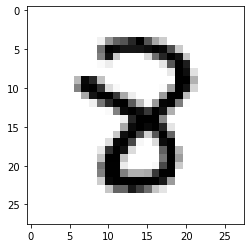

In [ ]:
index = 1118

imshow(test_set[index])

In [ ]:
activations = feed_forward(test_set[index], weights, biases)[-1]
print("output " + str(np.argmax(activations)))
print("expected " + str(test_label[index]))
activations


output 8
expected 8


array([1.70173136e-35, 1.19761953e-03, 1.26612249e-11, 7.55811142e-08,
       1.63273301e-15, 8.02964890e-19, 7.12355650e-10, 4.69565825e-29,
       8.22547278e-03, 5.85471929e-24])

In [ ]:
test(test_set, weights, biases, test_label)

0.7743